<a href="https://colab.research.google.com/github/AtlastDeepLearning/Intestinal-Parasite-Classification-LW-CNN/blob/main/efficientNet_B0_LW_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

# Grayscaled Feature Extraction in Efficientnet

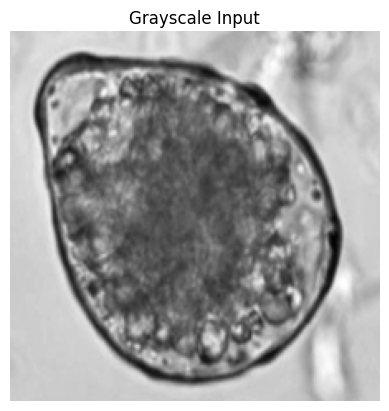

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img_path, target_size=(224, 224)):
    # Read image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Error: Could not load image from {img_path}")

    # Resize to model input size
    img = cv2.resize(img, target_size)

    # Expand to 3 channels for pretrained CNNs
    img = np.stack([img] * 3, axis=-1)

    # Normalize
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Example usage
img_path = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/train/ascaris_lumbricoides/(1) 21090.png"  # 👈 Make sure this file exists
gray_img = preprocess_image(img_path)

plt.imshow(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), cmap="gray")
plt.title("Grayscale Input")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


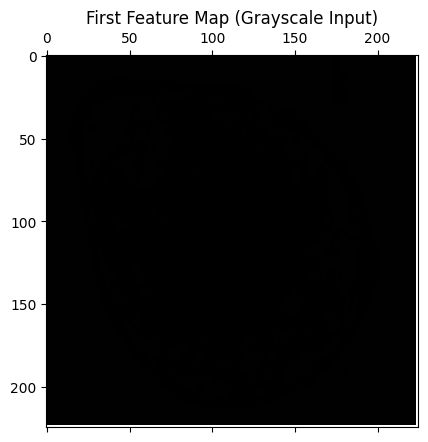

In [ ]:
# Extract activations from grayscale image
activations = activation_model.predict(gray_img)

# Visualize the first feature map from the first layer
plt.matshow(activations[0][0, :, :, 0], cmap='gray')
plt.title("First Feature Map (Grayscale Input)")
plt.show()

# Modified Grayscaled Feature Extraction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


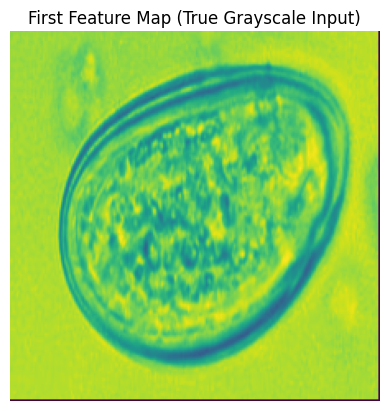

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Input
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 🔹 Load EfficientNetB0 but exclude top
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224,224,1))

# Example: Load and preprocess grayscale image
def preprocess_gray(img_path, target_size=(224,224)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or path incorrect")
    img = cv2.resize(img, target_size)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=-1)  # add channel dim
    img = np.expand_dims(img, axis=0)   # batch dim
    return img

# Get activations from first few conv layers
layer_names = [layer.name for layer in base_model.layers if "conv" in layer.name][:5]
activation_model = Model(inputs=base_model.input,
                         outputs=[base_model.get_layer(name).output for name in layer_names])

# Test with sample image
img_path = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/train/enterobius_vermicularis/(1).png"
gray_img = preprocess_gray(img_path)

activations = activation_model.predict(gray_img)

# Visualize the first feature map
first_activation = activations[0][0, :, :, 0]  # first conv, first channel
plt.imshow(first_activation, cmap="viridis")
plt.title("First Feature Map (True Grayscale Input)")
plt.axis("off")
plt.show()

# Training Code for Efficientnet b0

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [3]:
IMG_SIZE = (224, 224)  # EfficientNetB0 default
BATCH_SIZE = 16
EPOCHS = 30
DATASET_DIR_TRAIN = "/content/drive/MyDrive/Thesis/parasite_dataset/train"
DATASET_DIR_VAL = "/content/drive/MyDrive/Thesis/parasite_dataset/val"

In [4]:
def grayscale_to_rgb(img):
    # img is (H, W, 1), expand to (H, W, 3)
    return tf.image.grayscale_to_rgb(img)

def custom_preprocess(img):
    # Ensure values in [0,1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Expand grayscale to 3-channel
    img = grayscale_to_rgb(img)
    return img

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator() # No augmentation for validation

train_gen = train_datagen.flow_from_directory(
    f"{DATASET_DIR_TRAIN}",
    target_size=IMG_SIZE,
    color_mode="grayscale",   # load as grayscale first
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    f"{DATASET_DIR_VAL}",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Apply custom preprocessing to convert grayscale to RGB
def preprocess_generator(generator):
    for batch_x, batch_y in generator:
        yield custom_preprocess(batch_x), batch_y

train_gen_processed = preprocess_generator(train_gen)
val_gen_processed = preprocess_generator(val_gen)

Found 1200 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [6]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))  # force RGB input
)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
outputs = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Freeze base for transfer learning
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
checkpoint = ModelCheckpoint("efficientnet_parasite.h5", save_best_only=True, monitor="val_accuracy", mode="max")
earlystop = EarlyStopping(patience=5, restore_best_weights=True)

# -----------------------------
# Train
# -----------------------------
history = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=EPOCHS,
    callbacks=[checkpoint, earlystop],
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_steps=val_gen.samples // BATCH_SIZE
)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5895 - loss: 1.0011

75/75 ━━━━━━━━━━━━━━━━━━━━ 549s 7s/step - accuracy: 0.5917 - loss: 0.9975 - val_accuracy: 0.8661 - val_loss: 0.3841
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8883 - loss: 0.3571

75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 505ms/step - accuracy: 0.8885 - loss: 0.3565 - val_accuracy: 0.9732 - val_loss: 0.2052
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9569 - loss: 0.2150

75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step - accuracy: 0.9568 - loss: 0.2149 - val_accuracy: 0.9821 - val_loss: 0.0998
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - accuracy: 0.9380 - loss: 0.2185 - val_accuracy: 0.9808 - val_loss: 0.1084
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.9512 - loss: 0.1661 - val_accuracy: 0.9821 - val_loss: 0.0621
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9530 - loss: 0.1361

75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9531 - loss: 0.1361 - val_accuracy: 0.9904 - val_loss: 0.0805
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9661 - loss: 0.1332 - val_accuracy: 0.9712 - val_loss: 0.1018
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.9732 - loss: 0.0988 - val_accuracy: 0.9712 - val_loss: 0.1351
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.9808 - loss: 0.0970 - val_accuracy: 0.9808 - val_loss: 0.1354
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 274ms/step - accuracy: 0.9754 - loss: 0.0827 - val_accuracy: 0.9808 - val_loss: 0.1502


In [8]:
for layer in base_model.layers[-30:]:  # unfreeze last 30 layers
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=10,
    callbacks=[checkpoint, earlystop],
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_steps=val_gen.samples // BATCH_SIZE
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 317ms/step - accuracy: 0.9005 - loss: 0.3550 - val_accuracy: 0.9615 - val_loss: 0.1478
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 425ms/step - accuracy: 0.9279 - loss: 0.2913 - val_accuracy: 0.9643 - val_loss: 0.1599
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.9231 - loss: 0.2799 - val_accuracy: 0.9643 - val_loss: 0.1565
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.9480 - loss: 0.2143 - val_accuracy: 0.9732 - val_loss: 0.1397
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9659 - loss: 0.1763 - val_accuracy: 0.9712 - val_loss: 0.1469
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9595 - loss: 0.1630

75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.9594 - loss: 0.1631 - val_accuracy: 1.0000 - val_loss: 0.1180
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9641 - loss: 0.1757 - val_accuracy: 0.9808 - val_loss: 0.1083
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.9630 - loss: 0.1597 - val_accuracy: 0.9904 - val_loss: 0.0988
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.9678 - loss: 0.1403 - val_accuracy: 0.9615 - val_loss: 0.1427
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.9584 - loss: 0.1435 - val_accuracy: 0.9554 - val_loss: 0.1303


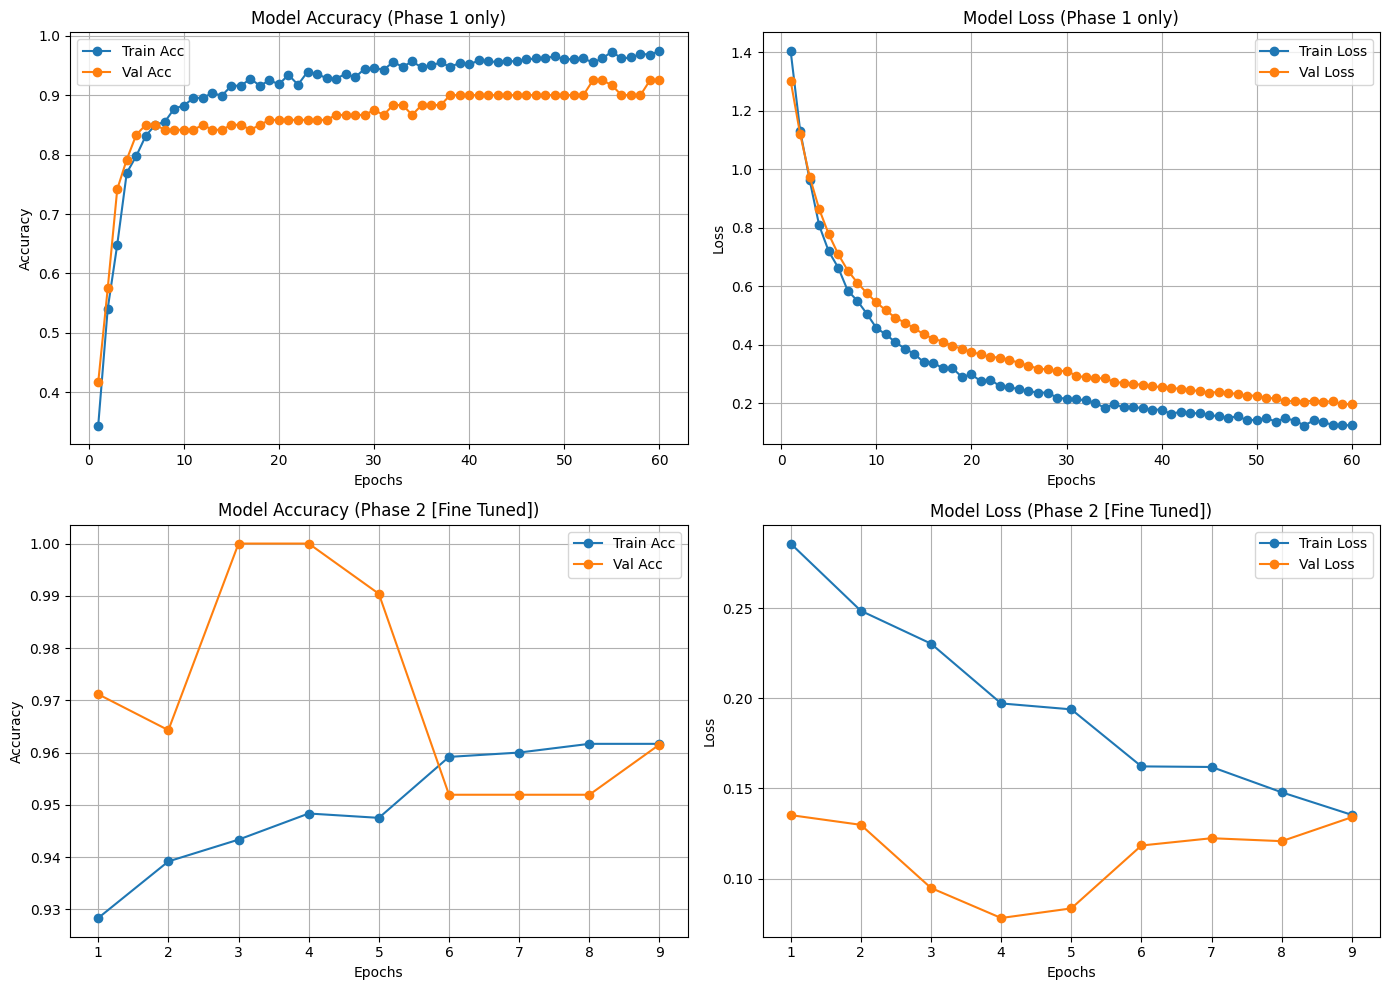

In [30]:
import matplotlib.pyplot as plt

# --- Phase 1 only ---
acc1 = history.history["accuracy"]
val_acc1 = history.history["val_accuracy"]
loss1 = history.history["loss"]
val_loss1 = history.history["val_loss"]

# --- Phase 2 only ---
acc2 = history_fine.history["accuracy"]
val_acc2 = history_fine.history["val_accuracy"]
loss2 = history_fine.history["loss"]
val_loss2 = history_fine.history["val_loss"]

epochs1 = range(1, len(acc1) + 1)
epochs2 = range(1, len(acc2) + 1)

plt.figure(figsize=(14,10))

# 1. Accuracy (Phase 1 only)
plt.subplot(2,2,1)
plt.plot(epochs1, acc1, label="Train Acc", marker="o")
plt.plot(epochs1, val_acc1, label="Val Acc", marker="o")
plt.title("Model Accuracy (Phase 1 only)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# 2. Loss (Phase 1 only)
plt.subplot(2,2,2)
plt.plot(epochs1, loss1, label="Train Loss", marker="o")
plt.plot(epochs1, val_loss1, label="Val Loss", marker="o")
plt.title("Model Loss (Phase 1 only)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 3. Accuracy (Phase 2 only, fine-tuning)
plt.subplot(2,2,3)
plt.plot(epochs2, acc2, label="Train Acc", marker="o")
plt.plot(epochs2, val_acc2, label="Val Acc", marker="o")
plt.title("Model Accuracy (Phase 2 [Fine Tuned])")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# 4. Loss (Phase 2 only, fine-tuning)
plt.subplot(2,2,4)
plt.plot(epochs2, loss2, label="Train Loss", marker="o")
plt.plot(epochs2, val_loss2, label="Val Loss", marker="o")
plt.title("Model Loss (Phase 2 [Fine Tuned])")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
val_gen.reset()
y_pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 969ms/step


In [12]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))


Classification Report:
              precision    recall  f1-score   support

     Ascaris     0.9091    1.0000    0.9524        30
  Enterobius     0.9677    1.0000    0.9836        30
   Hookworms     1.0000    0.9000    0.9474        30
   Trichuris     1.0000    0.9667    0.9831        30

    accuracy                         0.9667       120
   macro avg     0.9692    0.9667    0.9666       120
weighted avg     0.9692    0.9667    0.9666       120



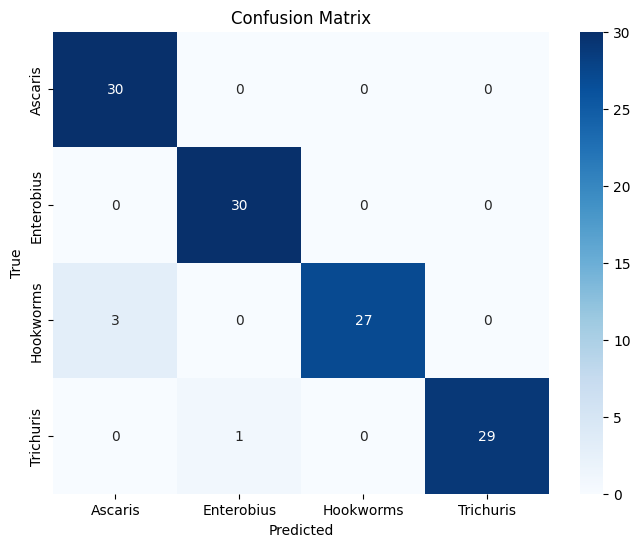

In [13]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Macro (treats all classes equally)
f1_macro = f1_score(y_true, y_pred, average="macro")
precision_macro = precision_score(y_true, y_pred, average="macro")
recall_macro = recall_score(y_true, y_pred, average="macro")

# Weighted (accounts for imbalance)
f1_weighted = f1_score(y_true, y_pred, average="weighted")
precision_weighted = precision_score(y_true, y_pred, average="weighted")
recall_weighted = recall_score(y_true, y_pred, average="weighted")

print("Macro Precision: {:.4f}, Macro Recall: {:.4f}, Macro F1: {:.4f}".format(
    precision_macro, recall_macro, f1_macro))
print("Weighted Precision: {:.4f}, Weighted Recall: {:.4f}, Weighted F1: {:.4f}".format(
    precision_weighted, recall_weighted, f1_weighted))

Macro Precision: 0.9692, Macro Recall: 0.9667, Macro F1: 0.9666
Weighted Precision: 0.9692, Weighted Recall: 0.9667, Weighted F1: 0.9666


In [17]:
model.save("efficientnet_parasite_final.keras")

# Save in TensorFlow SavedModel format
model.export("efficientnet_parasite_final")

Saved artifact at 'efficientnet_parasite_final'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')]
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136137111307472: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136137111307088: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136137146025552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136137146025360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136137146024592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136137151299024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136137146026704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136137146026896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136137146028624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136137146028816: TensorSpec(shape=(), dtype=tf.re

In [18]:
import tensorflow as tf
import numpy as np

IMG_SIZE = (224, 224)

def preprocess_image_inference(image_path):
    # Load grayscale first
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE, color_mode="grayscale")
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # (H,W,1)

    # Match training preprocessing
    img_array = tf.image.convert_image_dtype(img_array, tf.float32)  # [0,1]
    img_array = tf.image.grayscale_to_rgb(img_array)                 # (H,W,3)

    # Add batch dimension
    img_array = np.expand_dims(img_array.numpy(), axis=0)
    return img_array

In [19]:
img_batch = preprocess_image_inference("/content/drive/MyDrive/Thesis/dataset/train/enterobius_vermicularis/Enterobius vermicularis_0010.jpg")
pred = model.predict(img_batch)
predicted_class = np.argmax(pred, axis=1)[0]

print("Predicted:", list(train_gen.class_indices.keys())[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted: Enterobius_vermicularis


Found 120 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step

Classification Report:

              precision    recall  f1-score   support

     Ascaris       0.91      1.00      0.95        30
  Enterobius       0.97      1.00      0.98        30
   Hookworms       1.00      0.90      0.95        30
   Trichuris       1.00      0.97      0.98        30

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



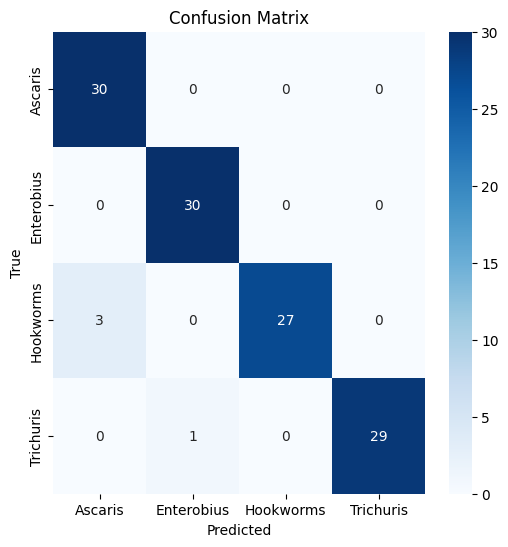

In [20]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# Config
# ======================
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
TEST_DIR = "/content/drive/MyDrive/Thesis/parasite_dataset/val"
MODEL_PATH = "/content/drive/MyDrive/Thesis/Saved AI models/sept82025_training/training_newdataset1/v2/efficientnet_parasite_final.keras"
# ======================
# Preprocessing (SAME as training)
# ======================
def grayscale_to_rgb(img):
    return tf.image.grayscale_to_rgb(img)

def custom_preprocess(img):
    img = tf.image.convert_image_dtype(img, tf.float32)  # scale [0,1]
    img = grayscale_to_rgb(img)                         # expand to RGB
    return img

def preprocess_generator(generator):
    for batch_x, batch_y in generator:
        yield custom_preprocess(batch_x), batch_y

# ======================
# Load Data
# ======================
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen_processed = preprocess_generator(test_gen)

# ======================
# Load Model
# ======================
model = tf.keras.models.load_model(MODEL_PATH)

# ======================
# Predictions
# ======================
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen_processed, steps=test_gen.samples // BATCH_SIZE + 1)
y_pred = np.argmax(y_pred_probs, axis=1)

# ======================
# Evaluation
# ======================
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# 2nd Test Training

In [23]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 60
DATASET_DIR_TRAIN = "/content/drive/MyDrive/Thesis/parasite_dataset/train"
DATASET_DIR_VAL = "/content/drive/MyDrive/Thesis/parasite_dataset/val"

In [24]:
def grayscale_to_rgb(img):
    return tf.image.grayscale_to_rgb(img)

def custom_preprocess(img):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = grayscale_to_rgb(img)
    return img

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_gen = train_datagen.flow_from_directory(
    DATASET_DIR_TRAIN,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    DATASET_DIR_VAL,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

def preprocess_generator(generator):
    for batch_x, batch_y in generator:
        yield custom_preprocess(batch_x), batch_y

train_gen_processed = preprocess_generator(train_gen)
val_gen_processed = preprocess_generator(val_gen)

Found 1200 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [25]:
# Base model
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
)

# Classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
outputs = Dense(
    train_gen.num_classes,
    activation="softmax",
    kernel_regularizer=l2(1e-4)
)(x)

model = Model(inputs=base_model.input, outputs=outputs)

# --- Phase 1: Train top layers ---
for layer in base_model.layers:
    layer.trainable = False  # freeze entire base model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)
]

steps_per_epoch = len(train_gen)
val_steps = len(val_gen)

history = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=callbacks
)

Epoch 1/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 320ms/step - accuracy: 0.2991 - loss: 1.4848 - val_accuracy: 0.4167 - val_loss: 1.3024 - learning_rate: 1.0000e-04
Epoch 2/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 0.5065 - loss: 1.1953 - val_accuracy: 0.5750 - val_loss: 1.1196 - learning_rate: 1.0000e-04
Epoch 3/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.6161 - loss: 1.0025 - val_accuracy: 0.7417 - val_loss: 0.9747 - learning_rate: 1.0000e-04
Epoch 4/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.7552 - loss: 0.8416 - val_accuracy: 0.7917 - val_loss: 0.8637 - learning_rate: 1.0000e-04
Epoch 5/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.7789 - loss: 0.7401 - val_accuracy: 0.8333 - val_loss: 0.7784 - learning_rate: 1.0000e-04
Epoch 6/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - accuracy: 0.8307 - loss: 0.6653 - val_accuracy: 0.8500 - val_loss: 0.7100 - learning_rate: 1.0000e-04
Epoch 7/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 272ms/step - acc

In [26]:
for layer in base_model.layers[-30:]:  # unfreeze last 30
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # smaller LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=10,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_steps=val_gen.samples // BATCH_SIZE,
    callbacks=[
        ModelCheckpoint("best_model_finetuned.keras", monitor="val_loss", save_best_only=True),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 332ms/step - accuracy: 0.9322 - loss: 0.2934 - val_accuracy: 0.9712 - val_loss: 0.1352
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - accuracy: 0.9245 - loss: 0.2761 - val_accuracy: 0.9643 - val_loss: 0.1298
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 0.9591 - loss: 0.2085 - val_accuracy: 1.0000 - val_loss: 0.0948
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9486 - loss: 0.1935 - val_accuracy: 1.0000 - val_loss: 0.0781
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.9490 - loss: 0.1927 - val_accuracy: 0.9904 - val_loss: 0.0835
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 271ms/step - accuracy: 0.9595 - loss: 0.1594 - val_accuracy: 0.9519 - val_loss: 0.1184
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.9446 - loss: 0.2014 - val_accuracy: 0.9519 - val_loss: 0.1224
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.9653 - loss: 0.1467 - val_accu

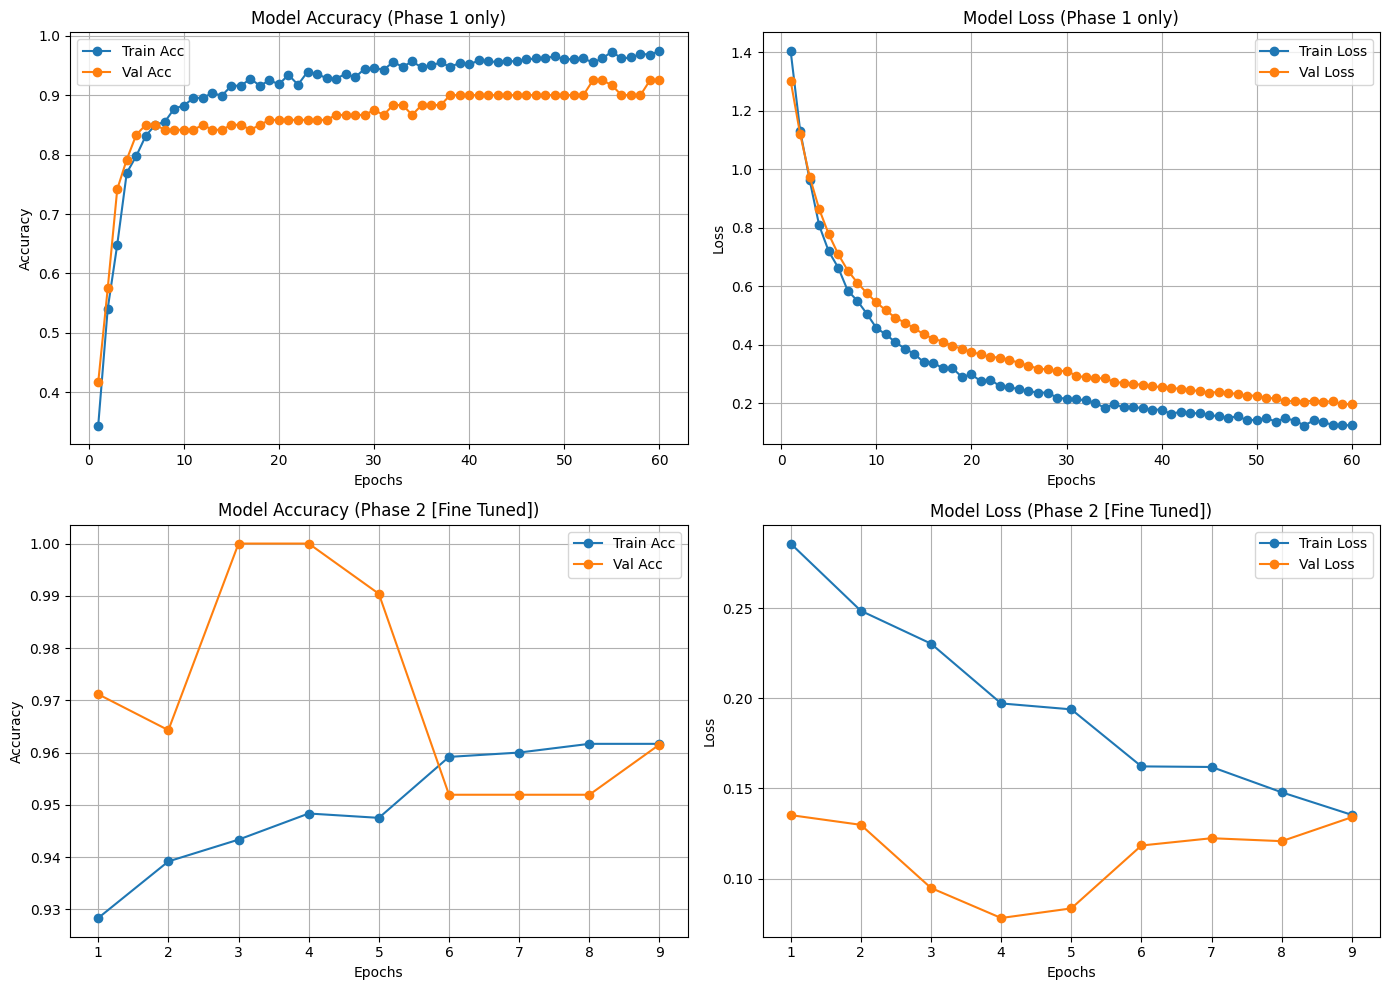

In [27]:
import matplotlib.pyplot as plt

# --- Phase 1 only ---
acc1 = history.history["accuracy"]
val_acc1 = history.history["val_accuracy"]
loss1 = history.history["loss"]
val_loss1 = history.history["val_loss"]

# --- Phase 2 only ---
acc2 = history_fine.history["accuracy"]
val_acc2 = history_fine.history["val_accuracy"]
loss2 = history_fine.history["loss"]
val_loss2 = history_fine.history["val_loss"]

epochs1 = range(1, len(acc1) + 1)
epochs2 = range(1, len(acc2) + 1)

plt.figure(figsize=(14,10))

# 1. Accuracy (Phase 1 only)
plt.subplot(2,2,1)
plt.plot(epochs1, acc1, label="Train Acc", marker="o")
plt.plot(epochs1, val_acc1, label="Val Acc", marker="o")
plt.title("Model Accuracy (Phase 1 only)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# 2. Loss (Phase 1 only)
plt.subplot(2,2,2)
plt.plot(epochs1, loss1, label="Train Loss", marker="o")
plt.plot(epochs1, val_loss1, label="Val Loss", marker="o")
plt.title("Model Loss (Phase 1 only)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 3. Accuracy (Phase 2 only, fine-tuning)
plt.subplot(2,2,3)
plt.plot(epochs2, acc2, label="Train Acc", marker="o")
plt.plot(epochs2, val_acc2, label="Val Acc", marker="o")
plt.title("Model Accuracy (Phase 2 [Fine Tuned])")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# 4. Loss (Phase 2 only, fine-tuning)
plt.subplot(2,2,4)
plt.plot(epochs2, loss2, label="Train Loss", marker="o")
plt.plot(epochs2, val_loss2, label="Val Loss", marker="o")
plt.title("Model Loss (Phase 2 [Fine Tuned])")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 912ms/step

Classification Report:
              precision    recall  f1-score   support

     Ascaris     1.0000    1.0000    1.0000        30
  Enterobius     0.9091    1.0000    0.9524        30
   Hookworms     0.9375    1.0000    0.9677        30
   Trichuris     1.0000    0.8333    0.9091        30

    accuracy                         0.9583       120
   macro avg     0.9616    0.9583    0.9573       120
weighted avg     0.9616    0.9583    0.9573       120



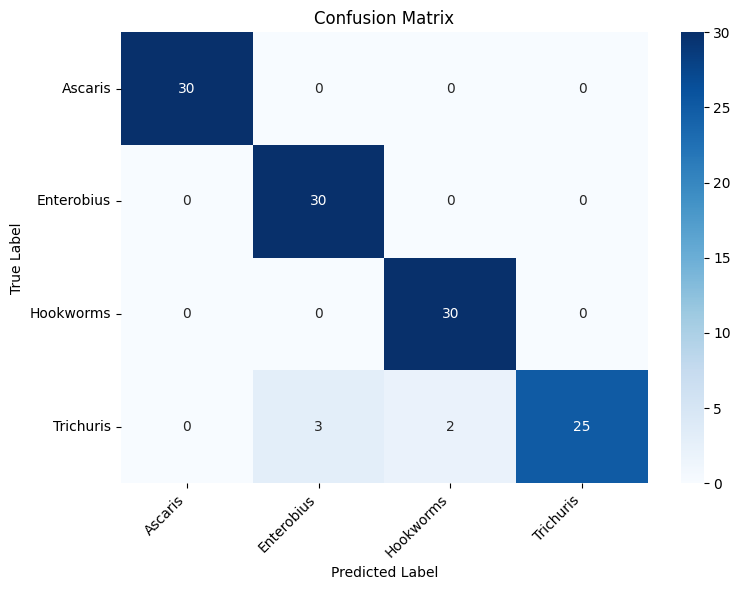

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Predictions ---
val_gen.reset()
y_pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_labels,
    digits=4,
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Found 30 images belonging to 3 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 12s/step

Classification Report:

                         precision    recall  f1-score   support

   ascaris_lumbricoides       0.75      0.90      0.82        10
enterobius_vermicularis       0.71      1.00      0.83        10
    trichuris_trichiura       1.00      0.40      0.57        10

               accuracy                           0.77        30
              macro avg       0.82      0.77      0.74        30
           weighted avg       0.82      0.77      0.74        30



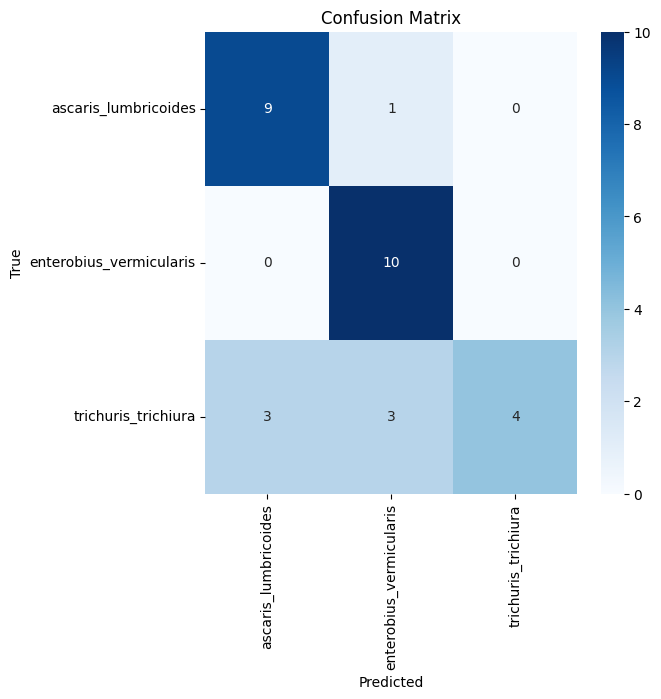

In [29]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# Config
# ======================
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
TEST_DIR = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/validate"
MODEL_PATH = "/content/drive/MyDrive/Thesis/Saved AI models/sept82025_training/training2/best_model_finetuned.keras"

# ======================
# Preprocessing (SAME as training)
# ======================
def grayscale_to_rgb(img):
    return tf.image.grayscale_to_rgb(img)

def custom_preprocess(img):
    img = tf.image.convert_image_dtype(img, tf.float32)  # scale [0,1]
    img = grayscale_to_rgb(img)                         # expand to RGB
    return img

def preprocess_generator(generator):
    for batch_x, batch_y in generator:
        yield custom_preprocess(batch_x), batch_y

# ======================
# Load Data
# ======================
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen_processed = preprocess_generator(test_gen)

# ======================
# Load Model
# ======================
model = tf.keras.models.load_model(MODEL_PATH)

# ======================
# Predictions
# ======================
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen_processed, steps=test_gen.samples // BATCH_SIZE + 1)
y_pred = np.argmax(y_pred_probs, axis=1)

# ======================
# Evaluation
# ======================
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# test

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- Focal Loss ---
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        ce = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow((1 - y_pred), gamma)
        return tf.reduce_sum(weight * ce, axis=1)
    return loss

# --- Base Model ---
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
)

# --- Classification Head ---
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
outputs = Dense(
    train_gen.num_classes,
    activation="softmax",
    kernel_regularizer=l2(1e-4)
)(x)

model = Model(inputs=base_model.input, outputs=outputs)

# --- Phase 1: Train head only ---
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=2., alpha=0.25),  # <---- focal loss
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)
]

steps_per_epoch = len(train_gen)
val_steps = len(val_gen)

history = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=callbacks
)

Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 661ms/step - accuracy: 0.2778 - loss: 0.2441 - val_accuracy: 0.2250 - val_loss: 0.2150 - learning_rate: 1.0000e-04
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.3572 - loss: 0.2087 - val_accuracy: 0.3250 - val_loss: 0.2019 - learning_rate: 1.0000e-04
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.4042 - loss: 0.1868 - val_accuracy: 0.3750 - val_loss: 0.1923 - learning_rate: 1.0000e-04
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.3996 - loss: 0.1739 - val_accuracy: 0.3500 - val_loss: 0.1841 - learning_rate: 1.0000e-04
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.5015 - loss: 0.1598 - val_accuracy: 0.3500 - val_loss: 0.1777 - learning_rate: 1.0000e-04
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.5192 - loss: 0.1540 - val_accuracy: 0.4000 - val_loss: 0.1707 - learning_rate: 1.0000e-04
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy:

In [ ]:
# --- Phase 2: Fine-tune last 30 layers ---
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=2., alpha=0.25),  # <---- focal loss again
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=10,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_steps=val_gen.samples // BATCH_SIZE,
    callbacks=[
        ModelCheckpoint("best_model_finetuned.keras", monitor="val_loss", save_best_only=True),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 719ms/step - accuracy: 0.7262 - loss: 0.1049 - val_accuracy: 0.4167 - val_loss: 0.1685
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.7968 - loss: 0.0703 - val_accuracy: 0.4583 - val_loss: 0.1678
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7856 - loss: 0.0778 - val_accuracy: 0.4583 - val_loss: 0.1696
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.7506 - loss: 0.0757 - val_accuracy: 0.4167 - val_loss: 0.1743
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.7628 - loss: 0.0786 - val_accuracy: 0.4167 - val_loss: 0.1757
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.8271 - loss: 0.0632 - val_accuracy: 0.4167 - val_loss: 0.1770
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.8205 - loss: 0.0690 - val_accuracy: 0.3750 - val_loss: 0.1777


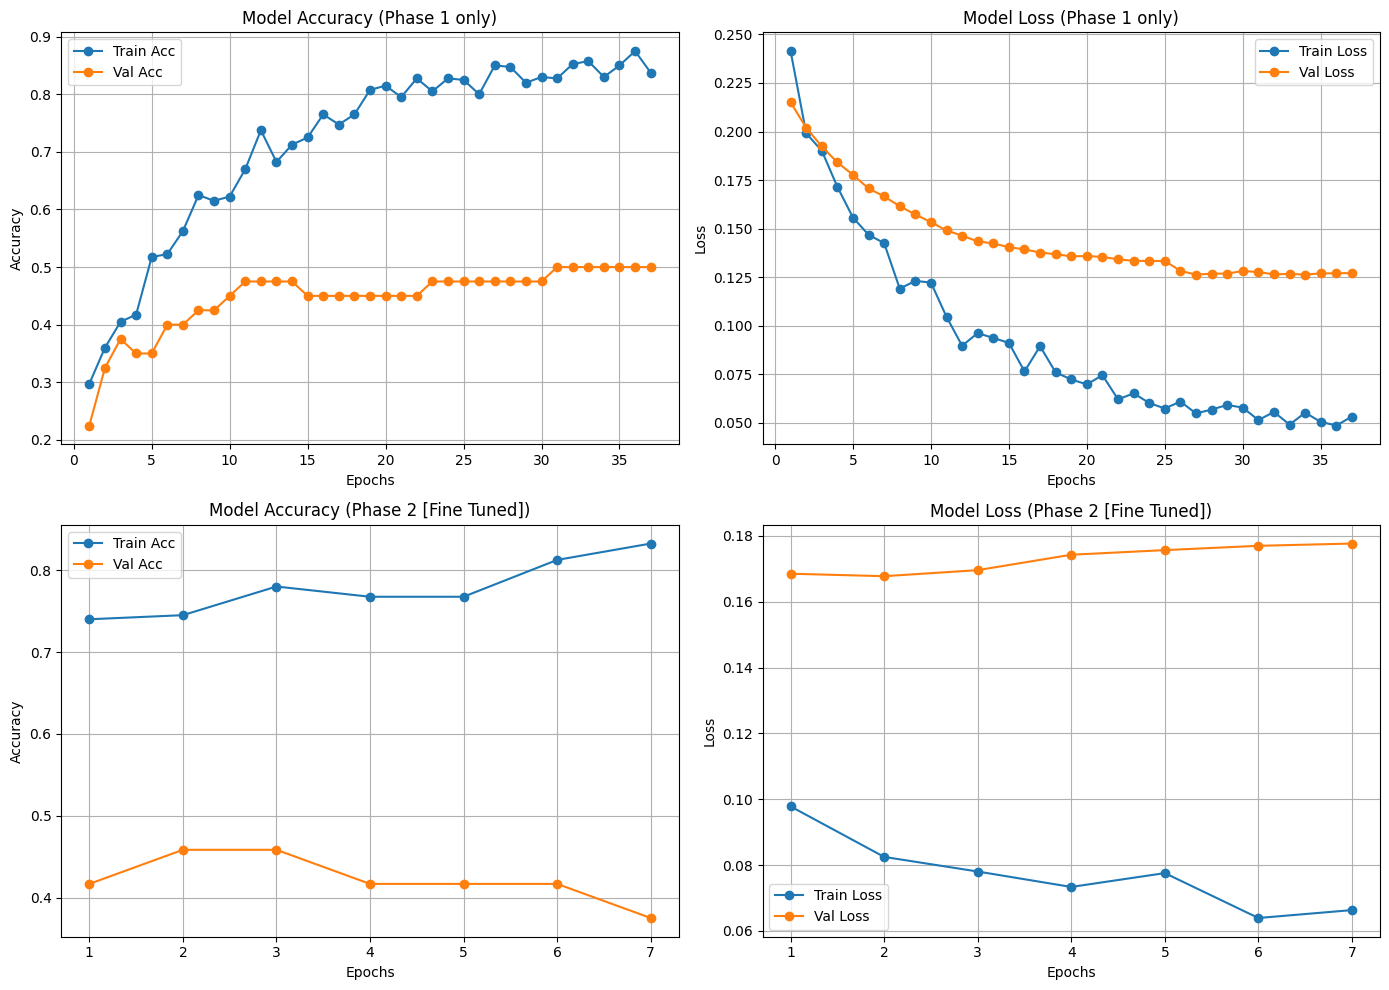

In [ ]:
import matplotlib.pyplot as plt

# --- Phase 1 only ---
acc1 = history.history["accuracy"]
val_acc1 = history.history["val_accuracy"]
loss1 = history.history["loss"]
val_loss1 = history.history["val_loss"]

# --- Phase 2 only ---
acc2 = history_fine.history["accuracy"]
val_acc2 = history_fine.history["val_accuracy"]
loss2 = history_fine.history["loss"]
val_loss2 = history_fine.history["val_loss"]

epochs1 = range(1, len(acc1) + 1)
epochs2 = range(1, len(acc2) + 1)

plt.figure(figsize=(14,10))

# 1. Accuracy (Phase 1 only)
plt.subplot(2,2,1)
plt.plot(epochs1, acc1, label="Train Acc", marker="o")
plt.plot(epochs1, val_acc1, label="Val Acc", marker="o")
plt.title("Model Accuracy (Phase 1 only)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# 2. Loss (Phase 1 only)
plt.subplot(2,2,2)
plt.plot(epochs1, loss1, label="Train Loss", marker="o")
plt.plot(epochs1, val_loss1, label="Val Loss", marker="o")
plt.title("Model Loss (Phase 1 only)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 3. Accuracy (Phase 2 only, fine-tuning)
plt.subplot(2,2,3)
plt.plot(epochs2, acc2, label="Train Acc", marker="o")
plt.plot(epochs2, val_acc2, label="Val Acc", marker="o")
plt.title("Model Accuracy (Phase 2 [Fine Tuned])")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# 4. Loss (Phase 2 only, fine-tuning)
plt.subplot(2,2,4)
plt.plot(epochs2, loss2, label="Train Loss", marker="o")
plt.plot(epochs2, val_loss2, label="Val Loss", marker="o")
plt.title("Model Loss (Phase 2 [Fine Tuned])")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step

Classification Report:
                         precision    recall  f1-score   support

   ascaris_lumbricoides     0.5833    0.7000    0.6364        10
enterobius_vermicularis     0.5263    1.0000    0.6897        10
              hookworms     1.0000    0.1000    0.1818        10
    trichuris_trichiura     0.7500    0.6000    0.6667        10

               accuracy                         0.6000        40
              macro avg     0.7149    0.6000    0.5436        40
           weighted avg     0.7149    0.6000    0.5436        40



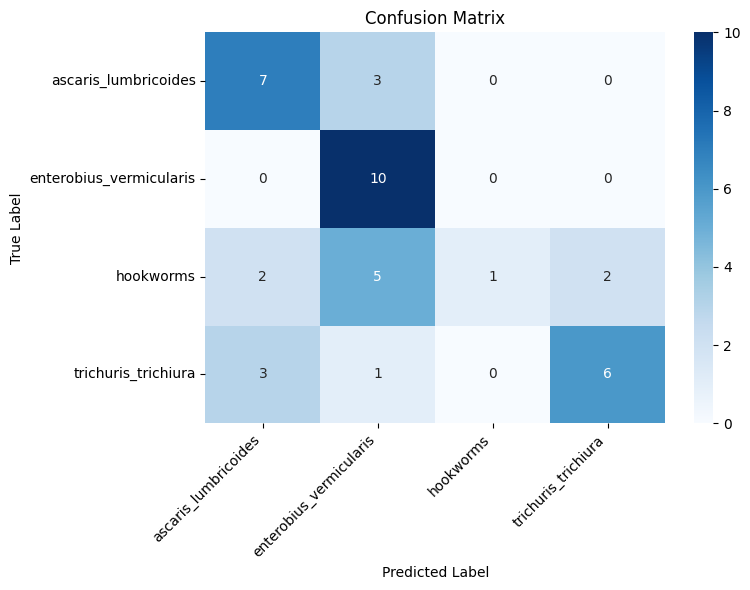

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Predictions ---
val_gen.reset()
y_pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_labels,
    digits=4,
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()